In [2]:
from pydub import AudioSegment
import numpy as np
from scipy.io import wavfile
import sys
import pandas as pd
import os 
from myprosody1 import myprosody
import time
import pickle
from tqdm import tqdm
import shutil

In [ ]:
import requests

audio_file = "/Users/User/Desktop/Audio_analysis/myprosody1/myprosody/dataset/audioFiles/est.mp3"

url = 'http://127.0.0.1:5000/api/analyze'
files = {'file': open(audio_file, 'rb')}
response = requests.post(url, files=files)

print(response.json())

{'articulation_rate': 5.0, 'balance': 0.7, 'number_of_pauses': 7.0, 'number_of_syllables': 81.0, 'original_duration': 23.6, 'rate_of_speech': 3.0, 'speaking_duration': 17.6}


In [ ]:
class Fluency:
    def __init__(self, filename, audio_path):
        self.audio_path = audio_path
        self.filename = filename

    def read_audio(self):
        """Read and prepare the audio file for analysis."""
        output_path = os.path.abspath("./myprosody1/myprosody/dataset/audioFiles/")

        # Check if the input file is a WAV file
        if not self.filename.lower().endswith('.wav'):

            out_audio = os.path.join(output_path, self.filename[:-3] + "wav")
            audio = AudioSegment.from_file(self.audio_path)
            audio.export(out_audio, format="wav")
            
        else:
            # If it's already a WAV file, copy it to the output location
            out_audio = os.path.join(output_path, self.filename)
            shutil.copy(self.audio_path, out_audio)
            print(f"Copied '{self.audio_path}' to '{out_audio}'.")

        # Read the WAV file
        sample_rate, audio_data = wavfile.read(out_audio)

        # Check sample rate and bit depth
        audio = AudioSegment.from_wav(out_audio)

        if sample_rate != 48000:
            print(f"Warning: Sample rate is {sample_rate} Hz, expected 48,000 Hz. Adjusting...")
            audio = audio.set_frame_rate(48000)  # Set sample rate to 48 kHz
            audio.export(out_audio, format="wav", codec="pcm_s24le")

        bit_depth = audio.sample_width * 8  # Convert sample width to bit depth
        if bit_depth < 24 or bit_depth > 32:
            print(f"Warning: Bit depth is {bit_depth} bits, expected between 24 and 32 bits. Adjusting...")
            audio = audio.set_sample_width(3)  # Set to 24 bits (3 bytes)
            audio.export(out_audio, format="wav", codec="pcm_s24le")

        print("Audio file is ready to be analyzed.")
    
    def get_result(self):

        self.read_audio()
        abs_path = os.path.abspath("./myprosody1/myprosody")
        result = myprosody.mysptotal1(self.filename[:-3] + "wav", abs_path)
        result = {key: float(value) if isinstance(value, str) and value.replace('.', '', 1).isdigit() else value for key, value in result.items()}
    
        return result

In [6]:
test_path = 'C:/Users/User/Downloads/est.mp3'
test_file = "est.mp3"

In [7]:
fluency= Fluency(test_file, test_path)
fluency.get_result()

Audio file is ready to be analyzed.


{'number_of_syllables': 81.0,
 'number_of_pauses': 7.0,
 'rate_of_speech': 3.0,
 'articulation_rate': 5.0,
 'speaking_duration': 17.6,
 'original_duration': 23.6,
 'balance': 0.7}

In [82]:
fluency= Fluency("C:/Users/User/Documents/Audacity/L2/2023-4-L2-2.wav", "2023-4-L2-2.wav")
fluency.get_result()

Moved 'C:/Users/User/Documents/Audacity/L2/2023-4-L2-2.wav' to './myprosody1/myprosody/dataset/audioFiles/2023-4-L2-2.wav'.
Audio file is ready to be analyzed.


,0
number_of_syllables,116
number_of_pauses,7
rate_of_speech,5
articulation_rate,6
speaking_duration,19.3
original_duration,23.4
balance,0.8


### Scoring system 

In [27]:
folder = "C:/Users/User/Desktop/Audio_analysis/myprosody1/myprosody"

sound=folder+"/"+"dataset"+"/"+"audioFiles"+"/audios/"
files = os.listdir(sound)

In [28]:
test = '2019-1-L2-1.wav'
myprosody.mysptotal1(test, folder)

,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance
0,70,5,3,4,17.3,20.6,0.8


In [47]:
dfs = []

for file in tqdm(files):
    start_time = time.time()  # Record the start time
    try:
        df = myprosody.mysptotal1(file, folder) 
    except IndexError:
        print(file)
        continue

    end_time = time.time()  # Record the end time

    df["file_name"] = file
    df["level"] = file.split('-')[2]
    df["time"] = end_time - start_time  

    dfs.append(df)

final_df = pd.concat(dfs, ignore_index = True)

100%|██████████| 173/173 [01:36<00:00,  1.79it/s]


In [48]:
column_order = ["level", "file_name", "time"] + [col for col in final_df.columns if col not in ["level", "file_name", "time"]]
final_df = final_df[column_order]

columns_to_convert = [
    "number_of_syllables",
    'number_of_pauses',
    'rate_of_speech',
    'articulation_rate',
    'speaking_duration',
    'original_duration',
    'balance'
]

for column in columns_to_convert:
    final_df[column] = pd.to_numeric(final_df[column], errors='coerce')

In [49]:
# Drop rows with NaN values
final_df = final_df.dropna()

# Reset the index
final_df = final_df.reset_index(drop=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   level                162 non-null    object 
 1   file_name            162 non-null    object 
 2   time                 162 non-null    float64
 3   number_of_syllables  162 non-null    float64
 4   number_of_pauses     162 non-null    float64
 5   rate_of_speech       162 non-null    float64
 6   articulation_rate    162 non-null    float64
 7   speaking_duration    162 non-null    float64
 8   original_duration    162 non-null    float64
 9   balance              162 non-null    float64
dtypes: float64(8), object(2)
memory usage: 12.8+ KB


In [ ]:
final_df['level'] = final_df['level'].str.replace('.wav', '')

In [76]:
final_df.to_csv("results.csv", index = False)

## Testing

In [5]:
final_df = pd.read_csv("results.csv")
final_df.head()

,level,file_name,time,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance
0,L2,2019-1-L2-.wav,0.730270,136.0,20.0,2.0,4.0,34.3,59.2,0.6
1,L2,2019-1-L2-1.wav,0.235524,70.0,5.0,3.0,4.0,17.3,20.6,0.8
2,L2,2019-1-L2-2.wav,0.130014,38.0,2.0,4.0,4.0,8.8,10.7,0.8
3,L2,2019-1-L2-3.wav,0.233511,84.0,4.0,4.0,4.0,19.0,20.8,0.9
4,L3,2019-1-L3-.wav,0.750307,175.0,29.0,3.0,5.0,37.6,59.5,0.6


In [21]:
mean_stats = final_df.groupby('level')[["number_of_pauses", "articulation_rate", 'balance']].mean()
mean_stats

,number_of_pauses,articulation_rate,balance
level,,,
L1,13.142857,4.000000,0.764286
L2,9.250000,4.500000,0.842857
L3,10.739130,4.586957,0.854348
L4,9.918919,4.648649,0.900000
L5,6.486486,4.891892,0.932432


In [101]:
from sklearn.preprocessing import MinMaxScaler

# Create scalers
min_max_scaler = MinMaxScaler()

# Fit and transform data using MinMaxScaler
scaled = min_max_scaler.fit_transform(final_df[["number_of_syllables",'number_of_pauses', 'rate_of_speech', 
                                                             'articulation_rate', 'speaking_duration', 
                                                             'original_duration', 'balance']])

df_scaled = pd.DataFrame(scaled, columns=["number_of_syllables", 'number_of_pauses', 'rate_of_speech', 
                                                               'articulation_rate', 'speaking_duration', 
                                                               'original_duration','balance'])


In [105]:
df_scaled['level'] = final_df["level"]
df_scaled['file_name'] = final_df["file_name"]
df_scaled['score'] = 2*df_scaled['articulation_rate'] + 2 * df_scaled['rate_of_speech'] + 2 * df_scaled["balance"] - df_scaled["number_of_pauses"]

In [106]:
df_scaled.describe()

,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,score
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,0.312428,0.328650,0.689300,0.534979,0.335862,0.375388,0.745679,3.611267
std,0.150738,0.217450,0.235341,0.183359,0.155994,0.168294,0.191788,1.109202
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.195402
25%,0.211663,0.172414,0.666667,0.333333,0.226322,0.251915,0.600000,3.117241
50%,0.302376,0.275862,0.666667,0.666667,0.334251,0.381291,0.800000,3.714943
75%,0.420626,0.482759,1.000000,0.666667,0.454846,0.528446,0.800000,4.582184
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.333333


In [ ]:
minmaxval = {
    "min": {'number_of_pauses': final_df["number_of_pauses"].min(), 
            'rate_of_speech': final_df["rate_of_speech"].min(), 
            'articulation_rate': final_df["articulation_rate"].min(),
            'balance': final_df["balance"].min()
    },

    "max": { 
            'number_of_pauses': final_df["number_of_pauses"].max(), 
            'rate_of_speech': final_df["rate_of_speech"].max(), 
            'articulation_rate': final_df["articulation_rate"].max(),
            'balance': final_df["balance"].max()
            }
}

# Specify the filename
filename = 'minmax.json'

# Save the dictionary as a JSON file
with open(filename, 'w') as json_file:
    json.dump(minmaxval, json_file, indent=4)

print(f'Dictionary saved as {filename}')

Dictionary saved as minmax.json


In [98]:
y = {
  "number_of_syllables": 136,
  "number_of_pauses": 20,
  "rate_of_speech": 2,
  "articulation_rate": 4,
  "speaking_duration": 34.3,
  "original_duration": 59.2,
  "balance": 0.6
}


In [ ]:
import numpy as np

def min_max_scale(value, min_value, max_value):
    scaled_value = (value - min_value) / (max_value - min_value)
    return scaled_value


def scaling(dict1):
    scaled_dict = {}
    for key in minmaxval["min"]:
        scaled_dict[key] = min_max_scale(dict1[key], minmaxval['min'][key], minmaxval['max'][key])


    score = scaled_dict['articulation_rate'] + scaled_dict['rate_of_speech'] + scaled_dict["balance"] - scaled_dict["number_of_pauses"]

    return scaled_dict, score

In [59]:
df_scaled = df_scaled[df_scaled["score"] > 0]

In [60]:
df_scaled.describe()

,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,score
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,0.313566,0.323060,0.697917,0.537500,0.336619,0.373297,0.753750,1.666106
std,0.151331,0.212693,0.223675,0.183100,0.156822,0.168289,0.178353,0.591813
min,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.200000,0.170115
25%,0.211123,0.172414,0.666667,0.333333,0.225220,0.250000,0.600000,1.317241
50%,0.305616,0.275862,0.666667,0.666667,0.338656,0.364880,0.800000,1.673563
75%,0.422786,0.456897,1.000000,0.666667,0.455121,0.528446,0.800000,2.130460
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.666667


In [61]:
df_scaled['score'] = df_scaled['articulation_rate'] + df_scaled['rate_of_speech'] + df_scaled["balance"] - df_scaled["number_of_pauses"]

In [62]:
mean_stats = df_scaled.groupby('level')[["number_of_syllables", "number_of_pauses", "rate_of_speech", "articulation_rate", 'balance', 'score']].mean()
mean_stats

,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,balance,score
level,,,,,,
L1,0.162319,0.421751,0.384615,0.333333,0.569231,0.865429
L2,0.226142,0.305236,0.592593,0.506173,0.703704,1.497233
L3,0.290919,0.370315,0.673913,0.528986,0.708696,1.541279
L4,0.372308,0.342032,0.729730,0.549550,0.800000,1.737248
L5,0.399918,0.223672,0.882883,0.630631,0.864865,2.154706


In [ ]:
mean_stats = df_scaled.groupby('level')[["number_of_syllables", "number_of_pauses", "rate_of_speech", "articulation_rate", 'balance', 'score']].mea()
mean_stats

,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,balance,score
level,,,,,,
L1,0.354212,0.896552,0.666667,0.666667,0.8,1.627586
L2,0.509719,0.758621,1.000000,1.000000,1.0,2.358621
L3,0.503240,1.000000,1.000000,1.000000,1.0,2.494253
L4,0.578834,0.896552,1.000000,0.666667,1.0,2.632184
L5,1.000000,0.482759,1.000000,0.666667,1.0,2.666667


In [20]:
df_scaled[df_scaled["level"] == "L1"]["score"]

19     0.960920
20     1.029885
21     0.926437
22     0.312644
60    -0.163218
61     0.627586
62     0.726437
63     0.393103
79     0.174713
80     0.142529
81     0.354023
137   -0.528736
138    0.342529
139    0.422989
Name: score, dtype: float64

In [ ]:
# <0.5 - L1
# 0.5-1.2 - L2

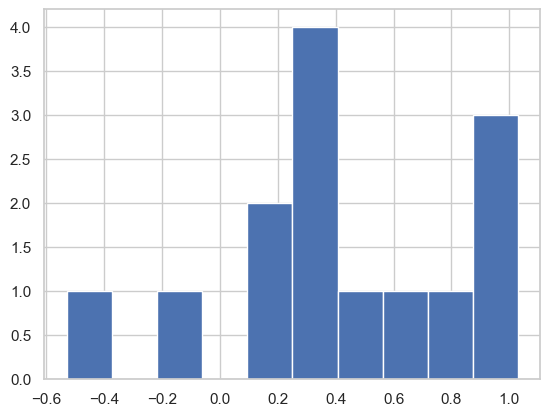

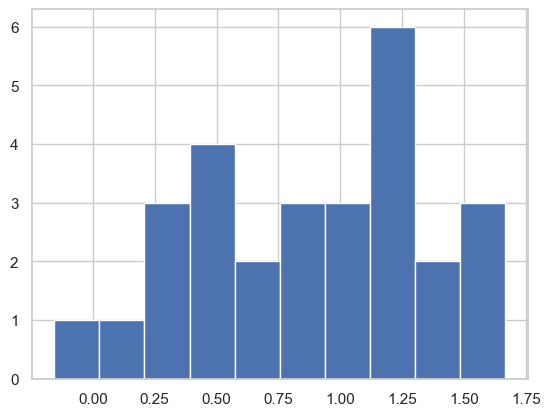

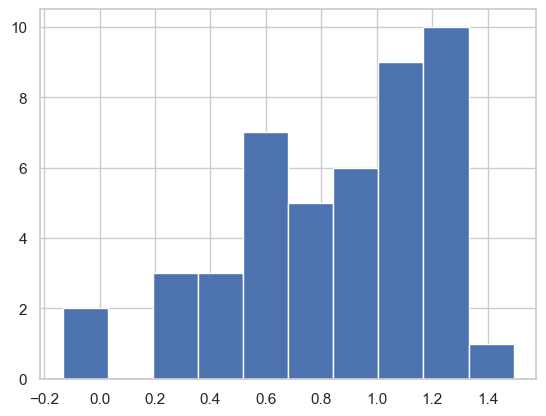

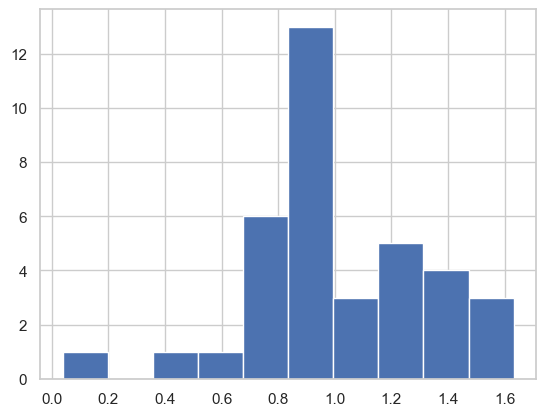

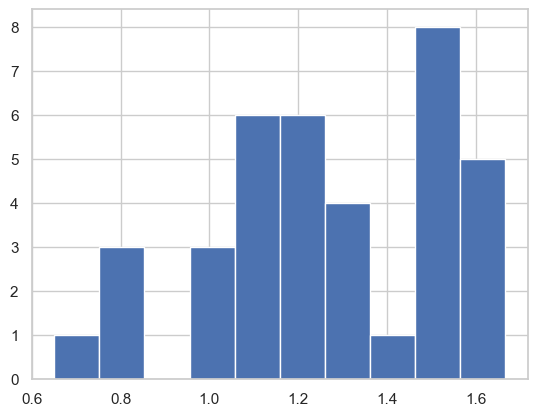

In [32]:
for i in range(1,6):    
    dist = df_scaled[df_scaled["level"] == ("L" + str(i))]["score"]
    plt.figure()
    plt.hist(dist)

In [ ]:
def weighted_average(df, value_col, weight_col):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

weighted = final_df.groupby('level').apply(lambda x: pd.Series({
    'number_of_syllables': weighted_average(x, 'number_of_syllables', 'original_duration'),
    'number_of_pauses': weighted_average(x, 'number_of_pauses', 'original_duration'),
    'rate_of_speech': weighted_average(x, 'rate_of_speech', 'original_duration'),
    'articulation_rate': weighted_average(x, 'articulation_rate', 'original_duration'),
    'balance': weighted_average(x, 'balance', 'original_duration'),
})).reset_index()


C:\Users\User\AppData\Local\Temp\ipykernel_1216\3497191112.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted = final_df.groupby('level').apply(lambda x: pd.Series({


In [34]:
weighted

,level,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,balance
0,L1,132.785917,15.768171,3.028884,4.059845,0.746404
1,L2,166.489364,10.813541,3.612375,4.462819,0.838346
2,L3,185.701188,12.102815,3.985526,4.596127,0.847225
3,L4,224.686852,10.832035,4.183440,4.669819,0.899430
4,L5,246.823248,6.816915,4.653929,4.897032,0.936650


In [48]:
weighted = df_scaled.groupby('level').apply(lambda x: pd.Series({
    'number_of_syllables': weighted_average(x, 'number_of_syllables', 'original_duration'),
    'number_of_pauses': weighted_average(x, 'number_of_pauses', 'original_duration'),
    'rate_of_speech': weighted_average(x, 'rate_of_speech', 'original_duration'),
    'articulation_rate': weighted_average(x, 'articulation_rate', 'original_duration'),
    'balance': weighted_average(x, 'balance', 'original_duration'),
    'score': weighted_average(x, 'score', 'original_duration')
})).reset_index()

C:\Users\User\AppData\Local\Temp\ipykernel_1216\1387368456.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted = df_scaled.groupby('level').apply(lambda x: pd.Series({


In [49]:
weighted

,level,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,balance,score
0,L1,0.219504,0.579427,0.337369,0.361148,0.478705,0.260426
1,L2,0.297405,0.393547,0.524437,0.482856,0.673234,0.762543
2,L3,0.328157,0.432652,0.657911,0.533038,0.689811,0.790196
3,L4,0.411562,0.382026,0.727295,0.558513,0.798553,0.975040
4,L5,0.465268,0.238242,0.885134,0.632822,0.875651,1.270231


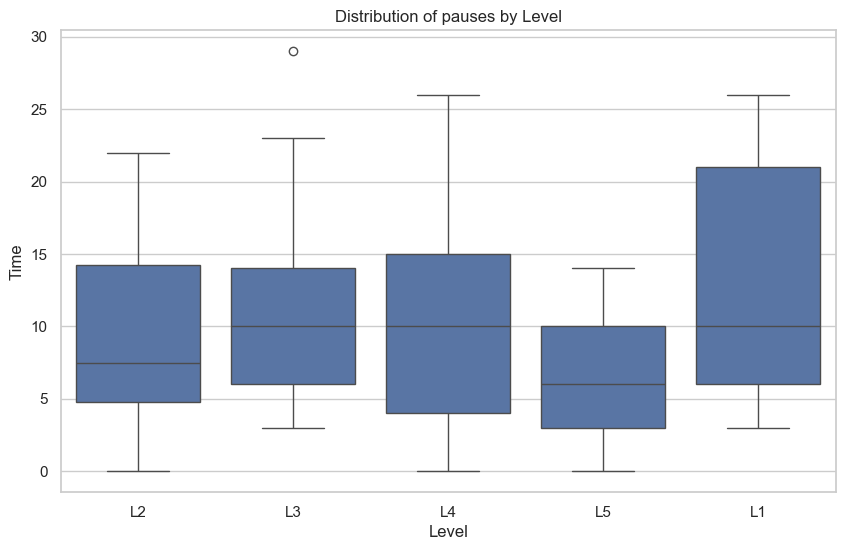

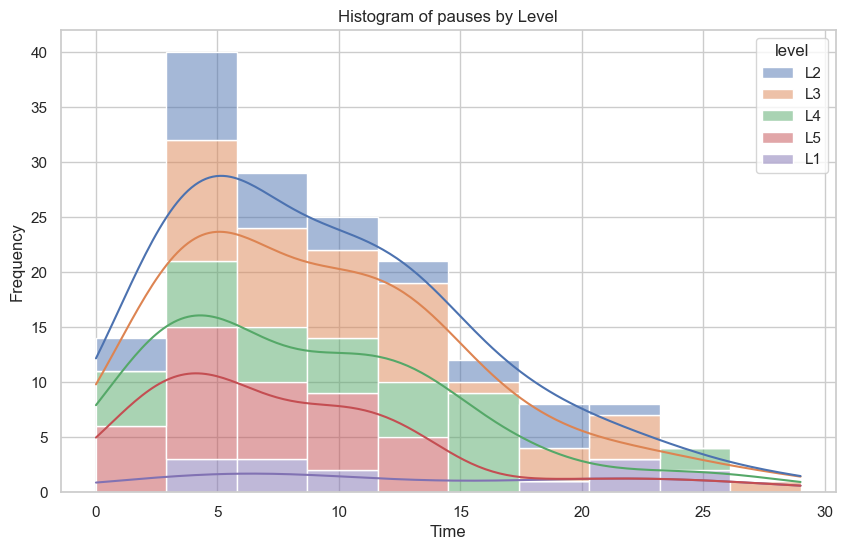

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a box plot for 'time' by 'level'
plt.figure(figsize=(10, 6))
sns.boxplot(x='level', y='number_of_pauses', data=final_df)
plt.title('Distribution of pauses by Level')
plt.xlabel('Level')
plt.ylabel('Time')
plt.show()

# Create a histogram for 'time' by 'level'
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='number_of_pauses', hue='level', multiple='stack', bins=10, kde=True)
plt.title('Histogram of pauses by Level')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

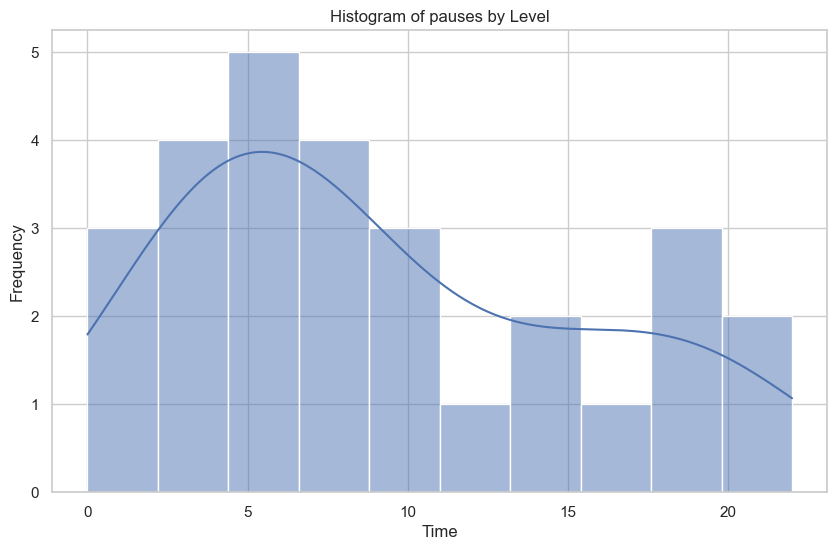

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = final_df[final_df['level'] == 'L2'], x='number_of_pauses', bins=10, kde=True)
plt.title('Histogram of pauses')
plt.xlabel('pauses')
plt.ylabel('Frequency')
plt.show()

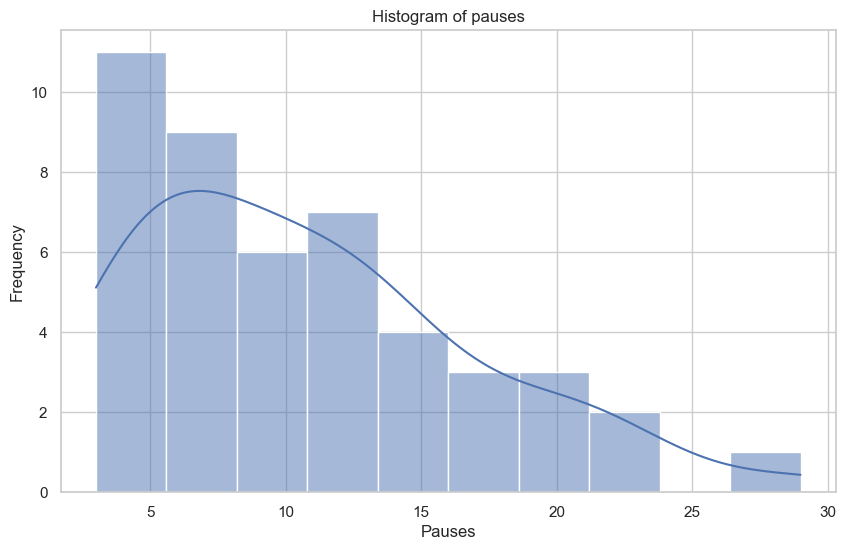

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(data = final_df[final_df['level'] == 'L3'], x='number_of_pauses', bins=10, kde=True)
plt.title('Histogram of pauses')
plt.xlabel('Pauses')
plt.ylabel('Frequency')
plt.show()

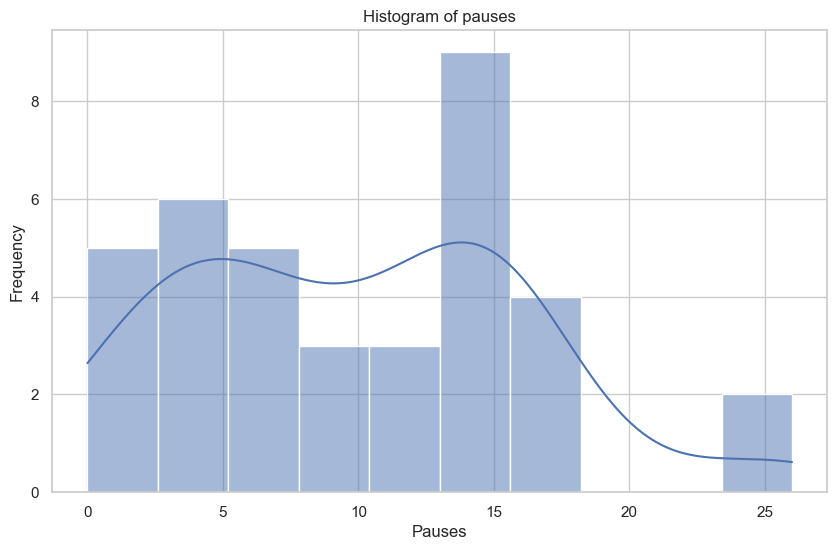

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data = final_df[final_df['level'] == 'L4'], x='number_of_pauses', bins=10, kde=True)
plt.title('Histogram of pauses')
plt.xlabel('Pauses')
plt.ylabel('Frequency')
plt.show()